In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance  # For SVC or KNN
import matplotlib.pyplot as plt

In [36]:
# Load datasets
train_data = pd.read_csv('data/train-dataset.csv', index_col=0)
test_data = pd.read_csv('data/test-dataset.csv', index_col=0)
dev_data = pd.read_csv('data/dev-dataset.csv', index_col=0)

In [37]:
train_data['TROPTHSMesswert'] = train_data['TROPTHSMesswert'].astype(int)
test_data['TROPTHSMesswert'] = test_data['TROPTHSMesswert'].astype(int)
dev_data['TROPTHSMesswert'] = dev_data['TROPTHSMesswert'].astype(int)

In [38]:
x_train = train_data.drop('TROPTHSMesswert', axis=1)
y_train = train_data['TROPTHSMesswert']

x_test = test_data.drop('TROPTHSMesswert', axis=1)
y_test = test_data['TROPTHSMesswert']

x_dev = dev_data.drop('TROPTHSMesswert', axis=1)
y_dev = dev_data['TROPTHSMesswert']

In [39]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(), 
    "Decision Tree": DecisionTreeClassifier(), 
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


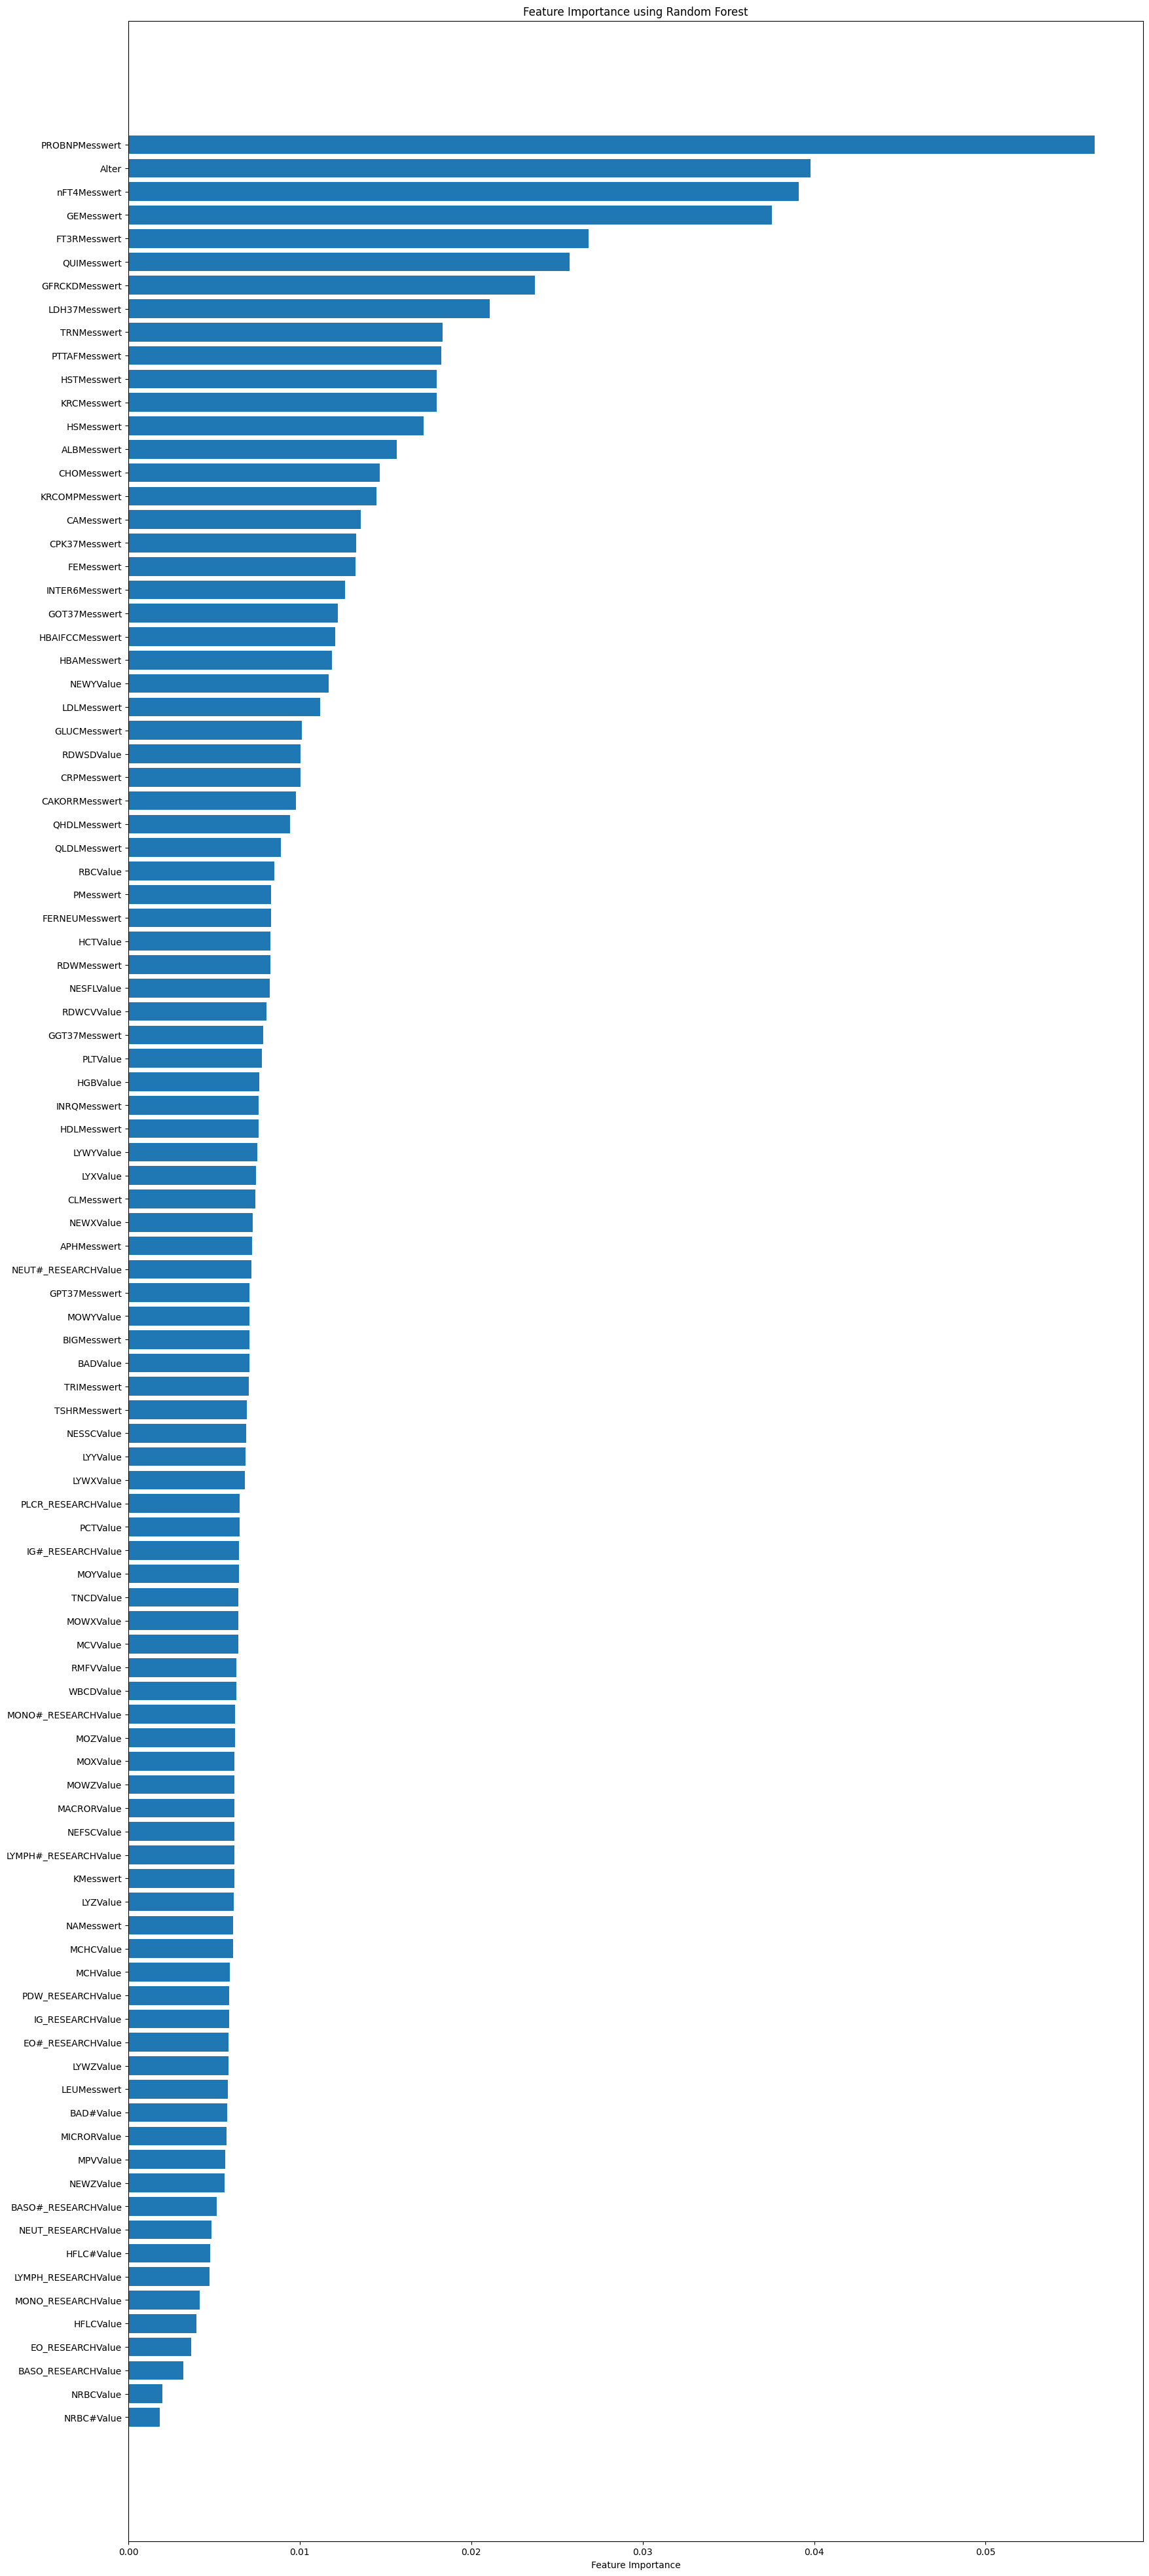

Error with Random Forest: [Errno 2] No such file or directory: '/Users/Fulya/Desktop/Bachelor Projekt/BachelorProject/Feature-Importance-Plots/Random Forest_feature_importance.png'


<Figure size 640x480 with 0 Axes>

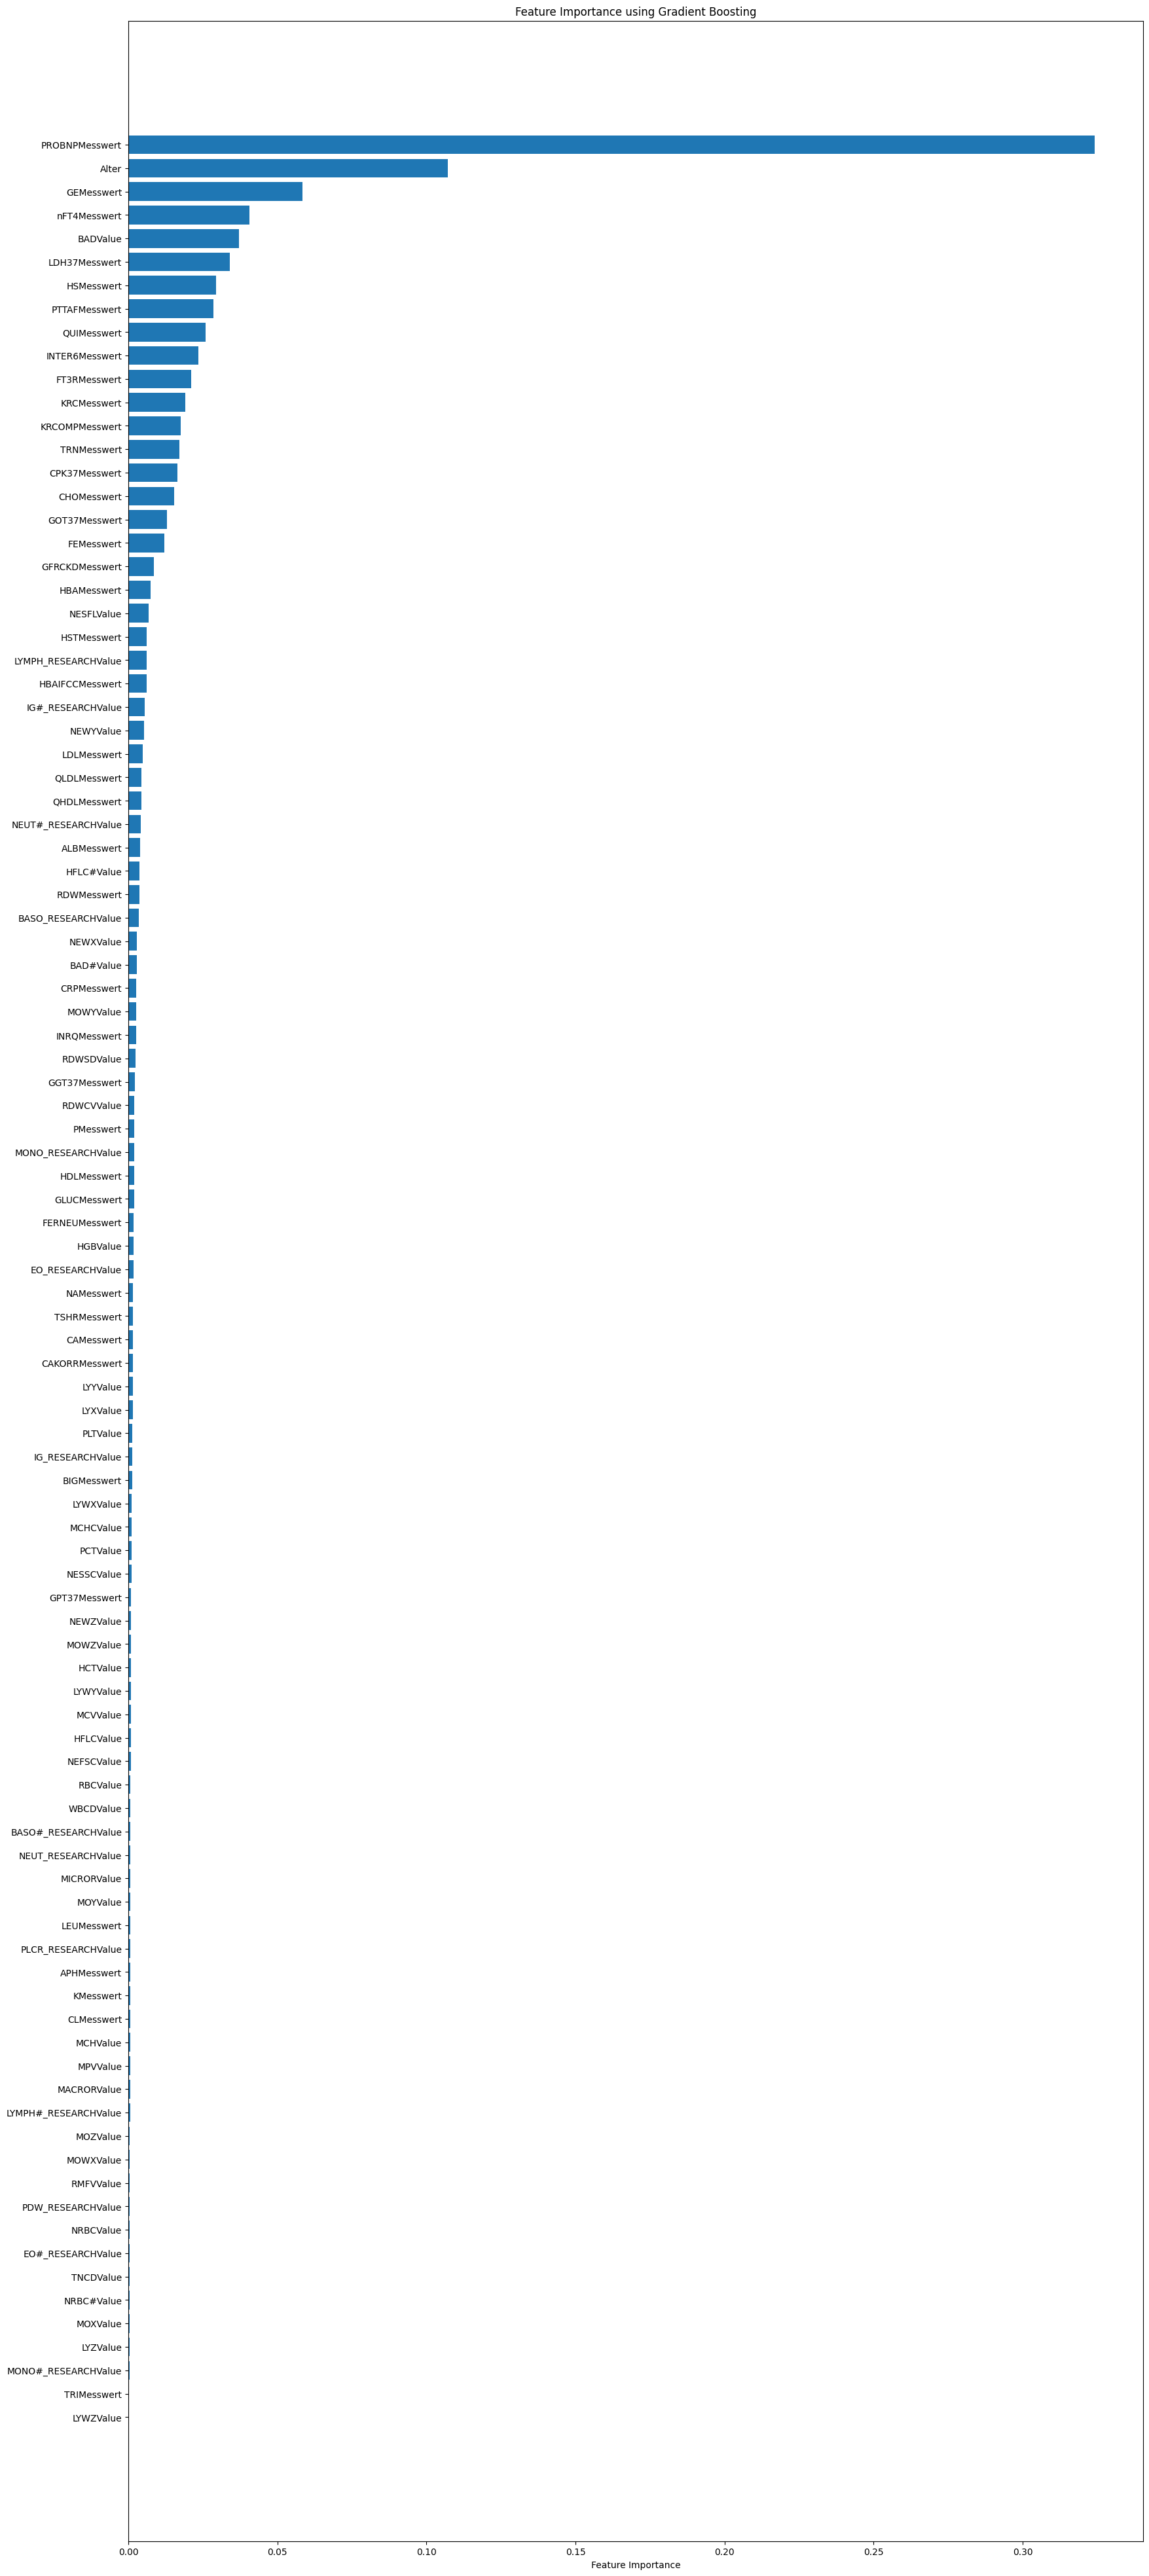

Error with Gradient Boosting: [Errno 2] No such file or directory: '/Users/Fulya/Desktop/Bachelor Projekt/BachelorProject/Feature-Importance-Plots/Gradient Boosting_feature_importance.png'


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

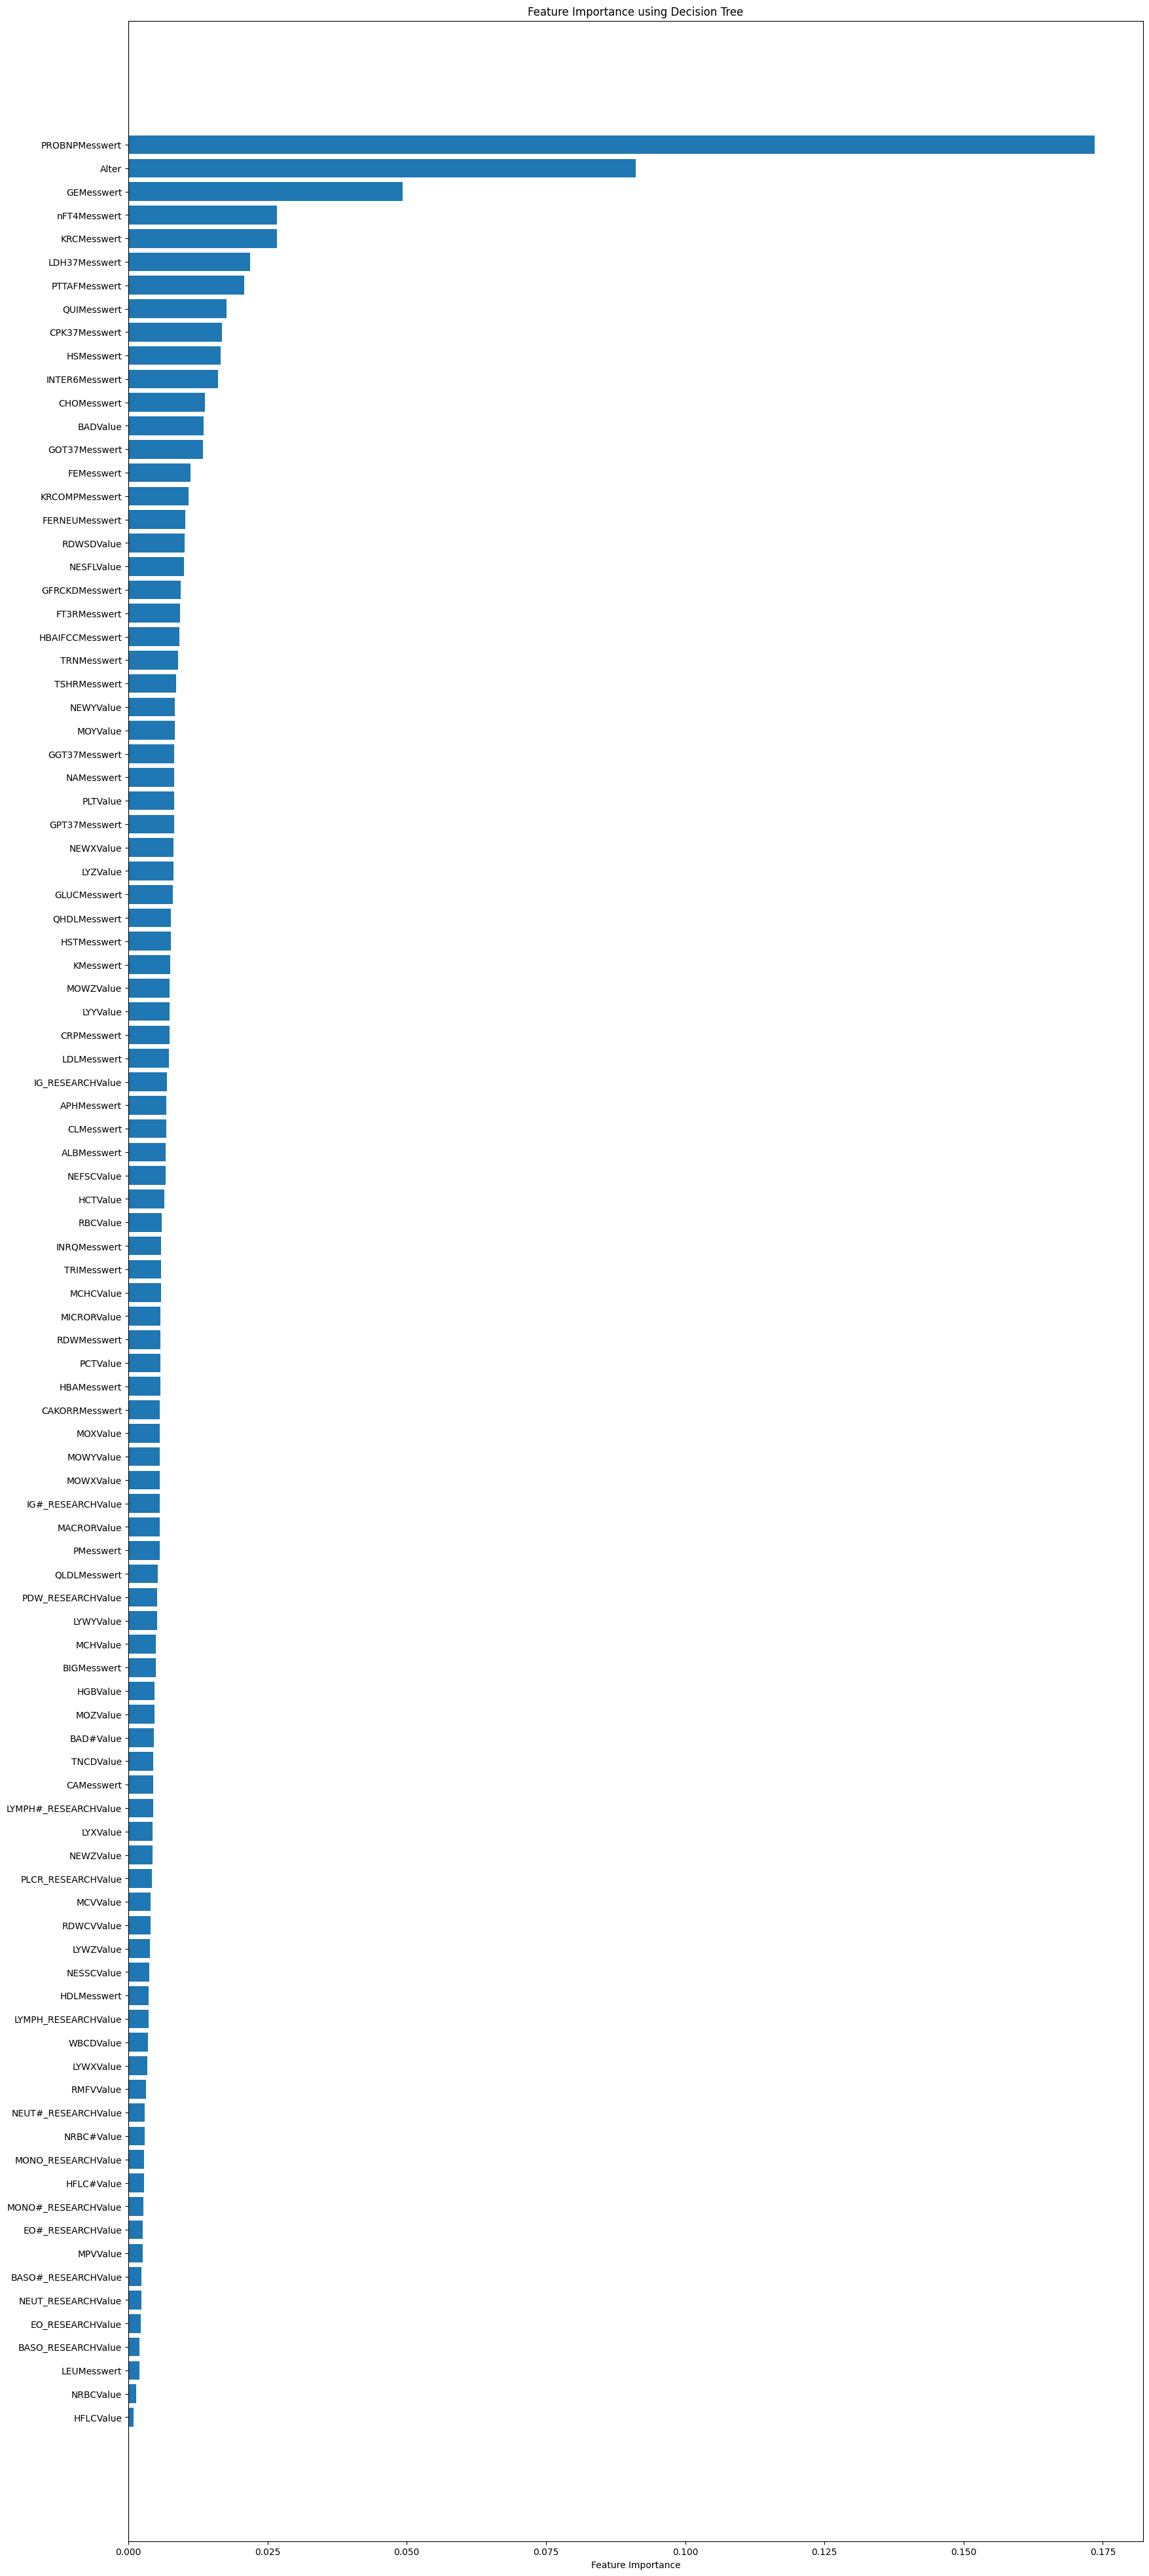

Error with Decision Tree: [Errno 2] No such file or directory: '/Users/Fulya/Desktop/Bachelor Projekt/BachelorProject/Feature-Importance-Plots/Decision Tree_feature_importance.png'
Model evaluation on the dev set:
Random Forest: Accuracy = 0.7097, F1 Score = 0.6672, Precision = 0.6621, Recall = 0.7097
Gradient Boosting: Accuracy = 0.7361, F1 Score = 0.7186, Precision = 0.7123, Recall = 0.7361
Decision Tree: Accuracy = 0.5937, F1 Score = 0.5984, Precision = 0.6038, Recall = 0.5937


<Figure size 640x480 with 0 Axes>

In [40]:
import os

best_model = None
best_accuracy = 0
best_f1 = 0
model_results = {}
feature_importances = {}


for model_name, model in models.items():
    try:
        model.fit(x_train, y_train)
        
        y_dev_pred = model.predict(x_dev)

        accuracy = accuracy_score(y_dev, y_dev_pred)
        f1 = f1_score(y_dev, y_dev_pred, average='weighted')
        precision = precision_score(y_dev, y_dev_pred, average='weighted')
        recall = recall_score(y_dev, y_dev_pred, average='weighted')

        model_results[model_name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }

        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy
            best_model = model

        if hasattr(model, 'feature_importances_'):
            feature_importances[model_name] = model.feature_importances_

        else:
            perm_importance = permutation_importance(model, x_dev, y_dev)
            feature_importances[model_name] = perm_importance.importances_mean

        feature_names = train_data.columns.drop('TROPTHSMesswert')  # Feature names
        importances = feature_importances[model_name]

        indices = np.argsort(importances)

        plt.figure(figsize=(20, 50))
        plt.title(f"Feature Importance using {model_name}")
        plt.barh(range(len(indices)), importances[indices], align="center")
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel("Feature Importance")
        plt.show()

        #export the plots
        plot_filename = f"{model_name}_feature_importance.png"
        plt.savefig(os.path.join("Feature-Importance-Plots/", plot_filename))

    except Exception as e:
        print(f"Error with {model_name}: {e}")

print("Model evaluation on the dev set:")
for model_name, metrics in model_results.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}, F1 Score = {metrics['f1_score']:.4f}, "
          f"Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}")

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score

precision_std_devs = {}

for model_name, model in models.items():
    try:
        precision_scores = cross_val_score(
            model, x_train, y_train, 
            cv=5,  # cross-validation folds
            scoring=make_scorer(precision_score, average='weighted')  
        )
        
        precision_std_dev = np.std(precision_scores)
        precision_std_devs[model_name] = precision_std_dev
        
        
        print(f"{model_name}: Precision Standard Deviation = {precision_std_dev:.4f}")
        
    except Exception as e:
        print(f"Error with {model_name}: {e}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/

Random Forest: Precision Standard Deviation = 0.0083


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Gradient Boosting: Precision Standard Deviation = 0.0034


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Decision Tree: Precision Standard Deviation = 0.0052


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Retraining Decision Tree according to feature importance

In [43]:
initial_tree = DecisionTreeClassifier()

# if it is not rounded the label is interpreted as continuous
initial_tree.fit(x_train, y_train)

selector = SelectFromModel(initial_tree, threshold="mean", prefit=True)

x_train_selected = selector.transform(x_train)  
x_test_selected = selector.transform(x_test)
x_dev_selected = selector.transform(x_dev)

feature_names = train_data.columns.drop('TROPTHSMesswert')  # Feature names
selected_features = selector.get_support(indices=True)
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected feature names: {feature_names[selected_features]}")

retrained_tree = DecisionTreeClassifier()
retrained_tree.fit(x_train_selected, y_train)

y_test_pred = retrained_tree.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

print(f"Retrained Decision Tree Performance on Test Set: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features: 18
Selected feature names: Index(['Alter', 'BADValue', 'CHOMesswert', 'CPK37Messwert', 'FEMesswert',
       'FERNEUMesswert', 'GEMesswert', 'GOT37Messwert', 'HSMesswert',
       'INTER6Messwert', 'KRCMesswert', 'KRCOMPMesswert', 'LDH37Messwert',
       'nFT4Messwert', 'PROBNPMesswert', 'PTTAFMesswert', 'QUIMesswert',
       'RDWSDValue'],
      dtype='object')
Retrained Decision Tree Performance on Test Set: Accuracy = 0.5821, F1 Score = 0.5833, Precision = 0.5846, Recall = 0.5821


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Retraining Gradient Boosting according to feature importance

In [44]:
initial_model = GradientBoostingClassifier()
initial_model.fit(x_train, y_train)
selector = SelectFromModel(initial_model, threshold="mean")


x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)
x_dev_selected = selector.transform(x_dev)

selected_features = selector.get_support(indices=True)
print(f"Number of features selected: {len(selected_features)}")
print(f"Selected feature names: {feature_names[selected_features]}")

retrained_model = GradientBoostingClassifier()
retrained_model.fit(x_train_selected, y_train)

y_test_pred = retrained_model.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

print(f"Retrained Model Performance on Test Set: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features selected: 18
Selected feature names: Index(['Alter', 'BADValue', 'CHOMesswert', 'CPK37Messwert', 'FEMesswert',
       'FT3RMesswert', 'GEMesswert', 'GOT37Messwert', 'HSMesswert',
       'INTER6Messwert', 'KRCMesswert', 'KRCOMPMesswert', 'LDH37Messwert',
       'nFT4Messwert', 'PROBNPMesswert', 'PTTAFMesswert', 'QUIMesswert',
       'TRNMesswert'],
      dtype='object')
Retrained Model Performance on Test Set: Accuracy = 0.7406, F1 Score = 0.7225, Precision = 0.7159, Recall = 0.7406


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Retraining Random Forest according to feature importance


In [45]:
initial_model = RandomForestClassifier(n_estimators=250, random_state=0)
initial_model.fit(x_train, y_train)
selector = SelectFromModel(initial_model, threshold="mean") 

x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)
x_dev_selected = selector.transform(x_dev)

selected_features = selector.get_support(indices=True)
print(f"Number of features selected: {len(selected_features)}")
print(f"Selected feature names: {feature_names[selected_features]}")

retrained_model = RandomForestClassifier(n_estimators=250, random_state=0)
retrained_model.fit(x_train_selected, y_train)

y_test_pred = retrained_model.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

print(f"Retrained Model Performance on Test Set: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features selected: 25
Selected feature names: Index(['Alter', 'ALBMesswert', 'CAMesswert', 'CHOMesswert', 'CPK37Messwert',
       'FEMesswert', 'FT3RMesswert', 'GEMesswert', 'GFRCKDMesswert',
       'GOT37Messwert', 'HBAIFCCMesswert', 'HBAMesswert', 'HSMesswert',
       'HSTMesswert', 'INTER6Messwert', 'KRCMesswert', 'KRCOMPMesswert',
       'LDH37Messwert', 'LDLMesswert', 'NEWYValue', 'nFT4Messwert',
       'PROBNPMesswert', 'PTTAFMesswert', 'QUIMesswert', 'TRNMesswert'],
      dtype='object')
Retrained Model Performance on Test Set: Accuracy = 0.7243, F1 Score = 0.6888, Precision = 0.6879, Recall = 0.7243


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
